#### 現場で使える機械学習 講座課題 - Car Fuel Consumption

- 問題設定 : 100kmあたりのガソリン消費量(consume)を予測

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数

# セルの表示行数を500行に拡張する
#pd.set_option("display.max_rows", 500)

#### 1. データの読み込み

##### 1.1. 入力ファイルとなるCSVのデータ
* distance : 走行距離(Km)
* consume : 100kmあたりのガソリン消費量(L/100km)
* speed : 平均速度(km/h)
* temp_inside : 車内の気温(${}^\circ$C)
* temp_outside : 外気温(${}^\circ$C)
* specials : 特記事項 : 雨(rain/half rain half sun)，雪，(snow)，エアコンの使用(AC)，出発時に車体が温かく感じるほどの晴れ(sun)
* gas_type : 使用ガソリンの種別 : SP98("Super plus")，E10("super" gas with 10% Alcohol)
* AC : エアコン使用の有無(0:False, 1:True)
* rain : 雨もしくは雪(0:False, 1:True)
* sun : 出発時に車体が温かく感じるほどの晴れ(0:False, 1:True)
* refill liters : 給油時のガソリン量(L)
* refill gas : 給油時のガソリンの種別 : SP98("Super plus")，E10("super" gas with 10% Alcohol)

##### 1.2. 入力データを量的 or 質的に種別分けする
* 量的変数 : distance, consume, speed, temp_inside, temp_outside, refill liters
* 質的変数 : specials, gas_type, AC, rain, sun, refill gas

##### 1.3. データの内容に対する考察
* 質的変数(specials)とダミー変数(AC, rain, sun)の関係が成り立つため specials は取り込まない
* rainとsunは「それ以外の天気」をカラムとして加えればone-hotエンコーディングの関係が成り立つ
* refill gas については、欠測値を補間した場合、データが gas_type と全件同一となるため取り込まない
* 問題設定より説明変数として使用することがないと判断し refill liters は取り込まない
* 質的変数(SP98, E10)はダミー変数(0, 1)に変換する方が特徴量を解析しやすい

In [2]:
# 提供者コメントのとおりデータの小数点記号がドイツ等で利用されるカンマであるため，read_csv時にdecimalオプションを指定する
# replaceを使用して質的変数(SP98, E10)はダミー変数(1, 0)に変換する
df_consume = pd.read_csv("../1_data/measurements.csv", decimal=",")[['distance', 'consume', 'speed',
                                                                     'temp_inside', 'temp_outside',
                                                                     'gas_type', 'AC', 'rain', 'sun']].replace({'SP98': 0, 'E10': 1})

# 取り込んだデータの欠測値の有無を確認
df_consume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 9 columns):
distance        388 non-null float64
consume         388 non-null float64
speed           388 non-null int64
temp_inside     376 non-null float64
temp_outside    388 non-null int64
gas_type        388 non-null int64
AC              388 non-null int64
rain            388 non-null int64
sun             388 non-null int64
dtypes: float64(3), int64(6)
memory usage: 27.4 KB


#### 2. データに対する前処理
* 欠測値の補間
* メモリ使用量低減のための型変換

In [3]:
# 上記infoにて判明したtemp_insideの欠測値を欠測の直前値で補間する
df_consume['temp_inside'] = df_consume['temp_inside'].fillna(method = 'ffill')

# メモリ使用量低減のために0と1しか使用しない質的変数のカラム属性をint8に変換する
df_consume['gas_type'] = df_consume['gas_type'].astype(np.int8)
df_consume['AC'] = df_consume['AC'].astype(np.int8)
df_consume['rain'] = df_consume['rain'].astype(np.int8)
df_consume['sun'] = df_consume['sun'].astype(np.int8)

# 欠測値補間とデータ型変更が適用されたことを確認
df_consume.info()

# 取り込んだデータを見る
display(df_consume.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 9 columns):
distance        388 non-null float64
consume         388 non-null float64
speed           388 non-null int64
temp_inside     388 non-null float64
temp_outside    388 non-null int64
gas_type        388 non-null int8
AC              388 non-null int8
rain            388 non-null int8
sun             388 non-null int8
dtypes: float64(3), int64(2), int8(4)
memory usage: 16.8 KB


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
0,28.0,5.0,26,21.5,12,1,0,0,0
1,12.0,4.2,30,21.5,13,1,0,0,0
2,11.2,5.5,38,21.5,15,1,0,0,0
3,12.9,3.9,36,21.5,14,1,0,0,0
4,18.5,4.5,46,21.5,15,1,0,0,0


#### 3. データの特徴を分析する
##### 3.1. 要約統計量の出力

In [4]:
# 要約統計量を出力する 
df_consume.describe().T

,count,mean,std,min,25%,50%,75%,max
distance,388.0,19.652835,22.667837,1.3,11.80,14.6,19.0,216.1
consume,388.0,4.912371,1.033172,3.3,4.30,4.7,5.3,12.2
speed,388.0,41.927835,13.598524,14.0,32.75,40.5,50.0,90.0
temp_inside,388.0,21.890464,1.035038,19.0,21.50,22.0,22.5,25.5
temp_outside,388.0,11.358247,6.991542,-5.0,7.00,10.0,16.0,31.0
gas_type,388.0,0.412371,0.492897,0.0,0.00,0.0,1.0,1.0
AC,388.0,0.077320,0.267443,0.0,0.00,0.0,0.0,1.0
rain,388.0,0.123711,0.329677,0.0,0.00,0.0,0.0,1.0
sun,388.0,0.082474,0.275441,0.0,0.00,0.0,0.0,1.0


##### 3.2. 密度図の出力
* 質的変数(gas_type, AC, rain, sun)と量的変数consumeとの間に相関関係があるのかを密度図で確認する
* 質的変数と量的変数の相関関係は相関比を算出すれば定量的に判断可能であるが、相関比算出関数の実装まで至らなかった<br>
　⇒DAY2提出時の課題としたい

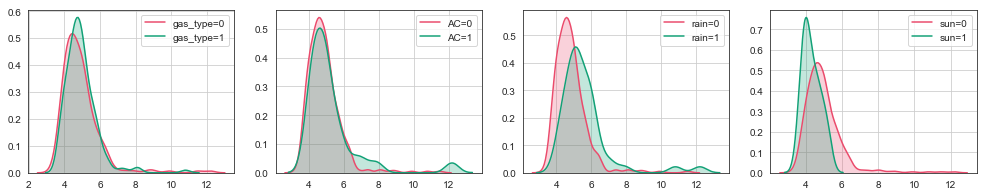

In [14]:
# warning出力時にjupyterがインストールされているフォルダが見えてしまうので抑制する
import warnings
warnings.filterwarnings('ignore')

# 質的変数(gas_type, AC, rain, sun)とconsumeとの間に相関関係があるのかを密度図で見る
fig, axes = plt.subplots(1, 4, figsize=(17, 3))
sns.set_style("whitegrid", {'axes.grid': True})

sns.kdeplot(df_consume[df_consume['gas_type'] == 0].consume, shade=True, color='#eb4b6c', ax=axes[0], label='gas_type=0');
sns.kdeplot(df_consume[df_consume['gas_type'] == 1].consume, shade=True, color='#12a177', ax=axes[0], label='gas_type=1');
sns.kdeplot(df_consume[df_consume['AC'] == 0].consume, shade=True, color='#eb4b6c', ax=axes[1], label='AC=0');
sns.kdeplot(df_consume[df_consume['AC'] == 1].consume, shade=True, color='#12a177', ax=axes[1], label='AC=1');
sns.kdeplot(df_consume[df_consume['rain'] == 0].consume, shade=True, color='#eb4b6c', ax=axes[2], label='rain=0');
sns.kdeplot(df_consume[df_consume['rain'] == 1].consume, shade=True, color='#12a177', ax=axes[2], label='rain=1');
sns.kdeplot(df_consume[df_consume['sun'] == 0].consume, shade=True, color='#eb4b6c', ax=axes[3], label='sun=0');
sns.kdeplot(df_consume[df_consume['sun'] == 1].consume, shade=True, color='#12a177', ax=axes[3], label='sun=1');

###### 3.2.1. 密度図に対する考察
* rainとconsumeの間には弱い相関関係がある<br>
  rain=1の場合、天気が雨/雪のため水の抵抗がある(A)→晴れや曇りの日より燃費が悪くなる(B)という「A→Bの因果関係がある」と考察される
* sunとconsumeの間には弱い相関関係がある<br>
  sun=1の場合、直射日光により車体が温かくなる(A)→燃費が良くなる(B)という「A→Bの因果関係がある」と考察される

##### 3.3. 散布図の出力
* 量的変数同士の相関関係を散布図にて確認する
* rainの値によって散布図の内容を色分けする

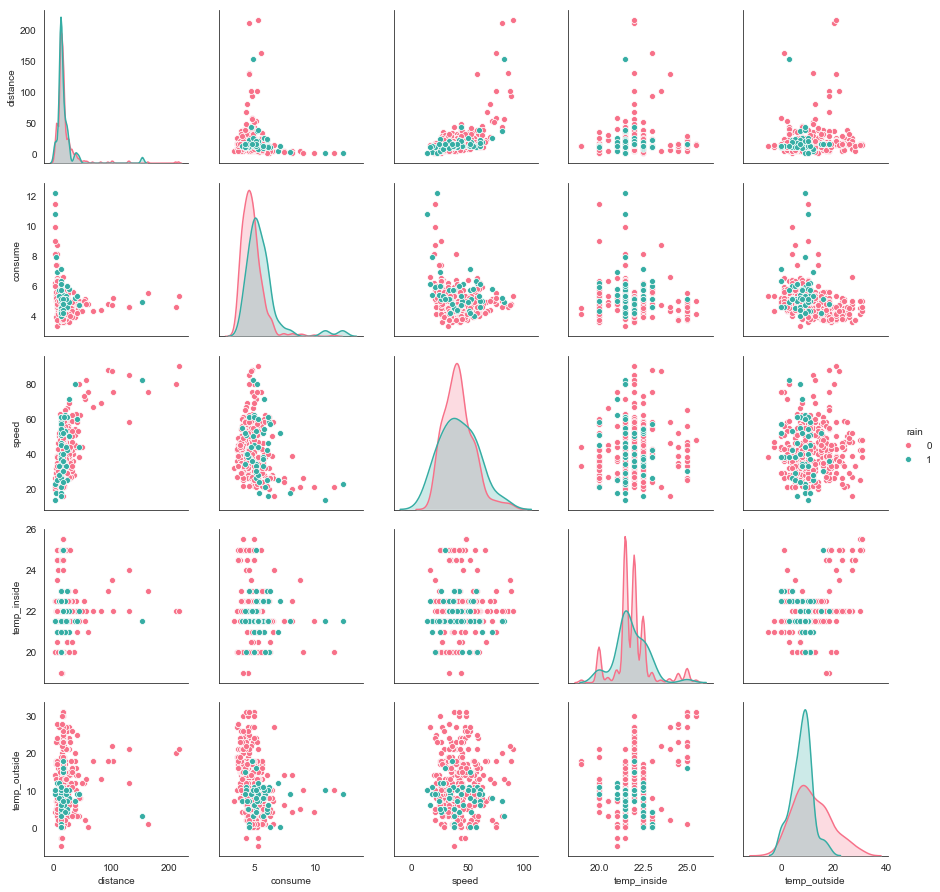

In [15]:
sns.set_style("white", {'axes.grid': False})

df_rain = df_consume.drop(['gas_type', 'AC', 'sun'], axis=1)

# 量的変数を対象として散布図行列を作成する
# 散布図行列の対角成分を3.2.の密度図と合わせる意図で，rainの値によって散布内容を色分けしている(rain=1のデータを緑色でプロットしている)
sns.pairplot(df_rain, hue='rain', vars=['distance', 'consume', 'speed', 'temp_inside', 'temp_outside'], palette='husl');

###### 3.3.1. 散布図に対する考察
* 目的変数consumeと他の量的変数との間それぞれにて外れ値をある程度整理すれば弱い相関関係があるように見える
* temp_outsideがconsumeに対して線形に近い分布に見える
* 客観的な特徴選択が可能ではなかったので相関係数の算出にて判断したい

##### 3.4. ヒートマップの出力
* 相関係数の値をヒートマップにて着色し確認する
* 質的変数と量的変数の相関関係について定量的に判断するために今回は相関比を使用せず相関係数にて代替する

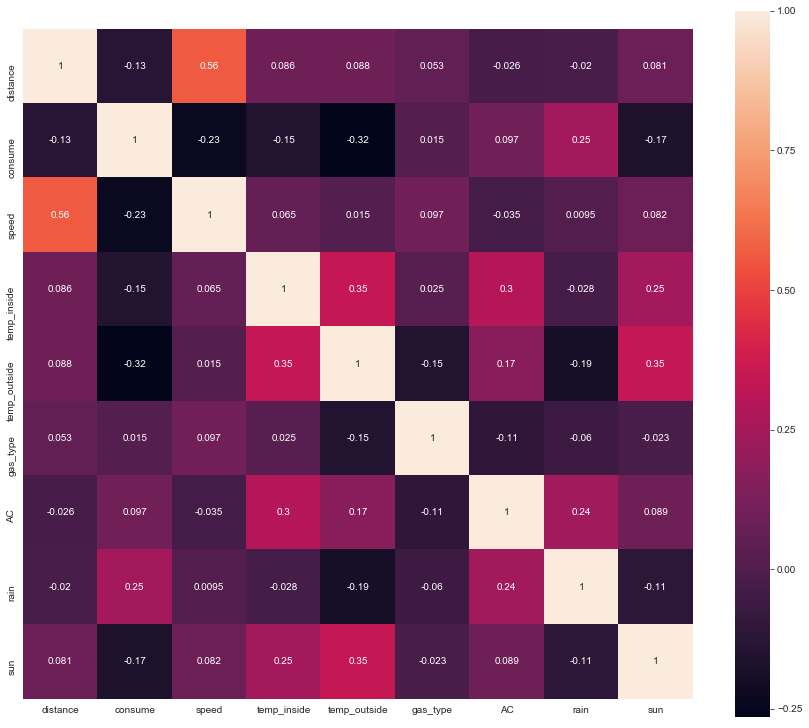

In [7]:
plt.figure(figsize=(15, 13))
# 相関係数をヒートマップにして可視化
sns.heatmap(df_consume.corr(), robust=True, annot=True, square=True);

###### 3.4.1. ヒートマップに対する考察
* 相関係数 r の値と相関の強さの関係として一般的に使用されるものは以下である

|相関係数|相関の強さ|
|---|---|
|0.7 ≤ &#124; r &#124;|強い相関あり|
|0.4 ≤ &#124; r &#124; < 0.7|中程度の相関あり|
|0.2 ≤ &#124; r &#124; < 0.4|弱い相関あり|
|&#124; r &#124; < 0.2|ほとんど相関なし|

よって目的変数consumeとの相関係数の絶対値 |r|が0.2以上となる以下の項目を説明変数とする (|r|の高い順)
* temp_outside (r=-0.32)　⇒　consumeと負の相関関係がある (外気温が高いとconsumeが低い = 燃費が良い)
* rain (r=0.25)　⇒　consumeと正の相関関係がある (雨/雪が降るとconsumeが高い = 燃費が悪い)
* speed (r=-0.23)　⇒　consumeと負の相関関係がある (平均時速が高いとconsumeが低い = 燃費が良い)

#### 4. 回帰分析を実行し精度評価指標値を取得する
* 線形回帰を実行する
* MSE, MAE, RMSEを取得し,RMSE/MAEの値も最終的な判断のために算出する

In [8]:
warnings.filterwarnings('default')

# 四捨五入した数値を返す関数
def r(data, precision):
    return np.round(data, decimals=precision)

##### 4.1. 回帰分析の実行と精度評価指標値の取得　その1
* temp_outsite, rain, speedを説明変数として線形回帰を実行する

In [9]:
# 説明変数をtemp_outside, rain, speedとする。

# 係数を求める
y = df_consume["consume"].values
X = df_consume[["temp_outside", "rain", "speed"]].values
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
w3 = regr.coef_[2]

# 変数の設定
x1 = df_consume["temp_outside"]
x2 = df_consume["rain"]
x3 = df_consume["speed"]
y = df_consume["consume"]

# 重みと二乗誤差の確認
y_est = w0 + w1 * x1 + w2 * x2 + w3 * x3
squared_error = 0.5 * np.sum((y - y_est) ** 2)
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, 二乗誤差 = {:.4f}'
      .format(w0, w1, w2, w3, squared_error))

# 値を予測
y_pred = regr.predict(X)

# MSEを計算
mse = mean_squared_error(y, y_pred) 
# MAEを計算
mae = mean_absolute_error(y, y_pred) 
# RMSEを計算
rmse = np.sqrt(mse)

pd_mean_error = pd.DataFrame(index={"精度評価指標値"}, data={"MSE":r(mse,4), "MAE":r(mae,4), "RMSE":r(rmse,4), "RMSE / MAE":r(rmse/mae,4)})
pd_mean_error

w0 = 6.024, w1 = -0.041, w2 = 0.621, w3 = -0.017, 二乗誤差 = 167.2097


,MSE,MAE,RMSE,RMSE / MAE
精度評価指標値,0.8619,0.6188,0.9284,1.5002


##### 4.2. 回帰分析の実行と精度評価指標値の取得　その2
* temp_outsite, rainを説明変数として線形回帰を実行する

In [10]:
# 説明変数をtemp_outside, rainとする。

# 係数を求める
y = df_consume["consume"].values
X = df_consume[["temp_outside", "rain"]].values
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]

# 変数の設定
x1 = df_consume["temp_outside"]
x2 = df_consume["rain"]
y = df_consume["consume"]

# 重みと二乗誤差の確認
y_est = w0 + w1 * x1 + w2 * x2
squared_error = 0.5 * np.sum((y - y_est) ** 2)
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, 二乗誤差 = {:.4f}'
      .format(w0, w1, w2, squared_error))

# 値を予測
y_pred = regr.predict(X)

# MSEを計算
mse = mean_squared_error(y, y_pred) 
# MAEを計算
mae = mean_absolute_error(y, y_pred) 
# RMSEを計算
rmse = np.sqrt(mse)

pd_mean_error = pd.DataFrame(index={"精度評価指標値"}, data={"MSE":r(mse,4), "MAE":r(mae,4), "RMSE":r(rmse,4), "RMSE / MAE":r(rmse/mae,4)})
pd_mean_error

w0 = 5.314, w1 = -0.042, w2 = 0.611, 二乗誤差 = 177.7016


,MSE,MAE,RMSE,RMSE / MAE
精度評価指標値,0.916,0.6109,0.9571,1.5666


##### 4.3. 回帰分析の実行と精度評価指標値の取得　その3
* temp_outsite, speedを説明変数として線形回帰を実行する

In [11]:
# 説明変数をtemp_outside, speedとする。

# 係数を求める
y = df_consume["consume"].values
X = df_consume[["temp_outside", "speed"]].values
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]

# 変数の設定
x1 = df_consume["temp_outside"]
x2 = df_consume["speed"]
y = df_consume["consume"]

# 重みと二乗誤差の確認
y_est = w0 + w1 * x1 + w2 * x2
squared_error = 0.5 * np.sum((y - y_est) ** 2)
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, 二乗誤差 = {:.4f}'
      .format(w0, w1, w2, squared_error))

# 値を予測
y_pred = regr.predict(X)

# MSEを計算
mse = mean_squared_error(y, y_pred) 
# MAEを計算
mae = mean_absolute_error(y, y_pred) 
# RMSEを計算
rmse = np.sqrt(mse)

pd_mean_error = pd.DataFrame(index={"精度評価指標値"}, data={"MSE":r(mse,4), "MAE":r(mae,4), "RMSE":r(rmse,4), "RMSE / MAE":r(rmse/mae,4)})
pd_mean_error

w0 = 6.155, w1 = -0.047, w2 = -0.017, 二乗誤差 = 175.0255


,MSE,MAE,RMSE,RMSE / MAE
精度評価指標値,0.9022,0.6332,0.9498,1.5001


##### 4.4. 回帰分析の実行と精度評価指標値の取得　その4
* temp_outsiteを説明変数として線形回帰を実行する

In [12]:
# 説明変数をtemp_outsideとする。

# 係数を求める
y = df_consume["consume"].values
X = df_consume[["temp_outside"]].values
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]

# 変数の設定
x1 = df_consume["temp_outside"]
y = df_consume["consume"]

# 重みと二乗誤差の確認
y_est = w0 + w1 * x1
squared_error = 0.5 * np.sum((y - y_est) ** 2)
print('w0 = {:.3f}, w1 = {:.3f}, 二乗誤差 = {:.4f}'
      .format(w0, w1, squared_error))

# 値を予測
y_pred = regr.predict(X)

# MSEを計算
mse = mean_squared_error(y, y_pred) 
# MAEを計算
mae = mean_absolute_error(y, y_pred) 
# RMSEを計算
rmse = np.sqrt(mse)

pd_mean_error = pd.DataFrame(index={"精度評価指標値"}, data={"MSE":r(mse,4), "MAE":r(mae,4), "RMSE":r(rmse,4), "RMSE / MAE":r(rmse/mae,4)})
pd_mean_error

w0 = 5.451, w1 = -0.047, 二乗誤差 = 185.2923


,MSE,MAE,RMSE,RMSE / MAE
精度評価指標値,0.9551,0.6271,0.9773,1.5585


#### 5. 精度評価指標値を評価する
* RMSE/MAEの値が1.253に一番近い値(誤差が正規分布に従う)を精度の高い特徴選択とする
* 結論として，RMSE/MAEの値が1.5001となったtemp_outside, speedが説明変数の回帰モデルが一番精度の高い予測値となると考察される